For the paper:
- Use https://arxiv.org/abs/1706.06103 for scattering
- Use term "optical depth" instead of lensing fraction, check that out
- Update parameters with https://arxiv.org/pdf/2208.00819.pdf
- Scattering in lens: 
    - https://arxiv.org/pdf/1706.06103.pdf
    - https://iopscience.iop.org/article/10.1088/0004-637X/776/2/125/pdf
- Compare rates to https://arxiv.org/pdf/2206.14310.pdf


TODO
- Update parameters with Clancy model
- Use "rate interpretation" of alpha (https://arxiv.org/pdf/2101.08005.pdfhttps://arxiv.org/pdf/2101.08005.pdf)
- Add other telescopes
- Add uncertainties
- Add magnification factor
- Add scattering horizon
- Same number of FRBs for lensed simulations

In [1]:
import warnings
warnings.filterwarnings("error")

In [2]:
import sys
sys.path.append("/arc/home/michilli/.local/lib/python3.8/site-packages/")

In [19]:
freq = 600 * u.MHz
sefd = (
    100 * u.Jy + 
    34 * u.K * (freq / 408 / u.MHz)**-2.6 / 
    (1.38 * u.K / u.Jy)
)

In [20]:
sefd

<Quantity 109.03905447 Jy>

In [25]:
a = rng.normal(size=100000, loc=sefd.value, scale=sefd.value * 0.2)

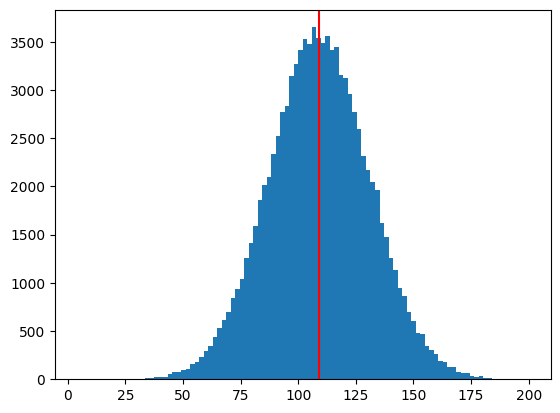

In [28]:
_=plt.hist(a, bins=100)
plt.axvline(sefd.value, color='r')

In [32]:
# Python 3.8.16
import os
import pickle
import datetime

# Numpy 1.24.2
import numpy as np
from numpy.random import default_rng
# matplotlib 3.7.1
import matplotlib.pyplot as plt
# astropy 5.2.1
from astropy import units as u
from astropy.coordinates import Distance
from astropy import constants as const
from astropy.cosmology import Planck18 as cosmo
# scipy 1.9.3
from scipy.special import j1
from scipy import optimize
from scipy.stats import truncnorm
from scipy.ndimage import gaussian_filter as gf
from scipy.interpolate import CubicSpline as spline
from scipy import integrate
# mpmath 1.3.0
from mpmath import gammainc



# Classes and functions

class Telescope:
    """
    Telescope parameters
    """
    parameters = {
        'dummy': {  # test parameters
            'Srec': 15 * u.Jy,
            'v0': 800 * u.MHz,
            'v1': 1600 * u.MHz,
            'D': 50 * u.m,
            'bands': [
                [800 * u.MHz, 1200 * u.MHz],
                [1200 * u.MHz, 1600 * u.MHz],
            ]
        },
        'chime': {  # from https://ui.adsabs.harvard.edu/abs/2022ApJS..261...29C/abstract
            # from https://ui.adsabs.harvard.edu/abs/2017ApJ...844..140C/abstract
            'Srec': 50 / 1.38 * u.Jy,
            'gain': 1.38 * u.K / u.Jy,
            'v0': 400 * u.MHz,
            'v1': 800 * u.MHz,            
            'Dx': 20 * u.m,
            'Dy': 0.87 * u.m,  # Emprirical value to have a beam of ~100 deg
        },
        'chord': {  # from https://ui.adsabs.harvard.edu/abs/2019clrp.2020...28V/abstract
            'Srec': 9 * u.Jy,
            'gain': 30 * u.K / 9 / u.Jy,
            'v0': 300 * u.MHz,
            'v1': 1500 * u.MHz,
            'D': 6 * u.m,
            'bands': [
                [300 * u.MHz, 700 * u.MHz],
                [700 * u.MHz, 1100 * u.MHz],
                [1100 * u.MHz, 1500 * u.MHz],
            ]
        },
        'dsa2000': {  # from https://ui.adsabs.harvard.edu/abs/2019BAAS...51g.255H/abstract
            'Srec': 2.5 * u.Jy,  # Jy
            'gain': 25 * u.K / 2.5 / u.Jy,
            'v0': 700 * u.MHz,
            'v1': 2000 * u.MHz,
            'D': 5 * u.m,
            'bands': [
                [700 * u.MHz, 1100 * u.MHz],
                [1100 * u.MHz, 1500 * u.MHz],
                [1500 * u.MHz, 2000 * u.MHz],
            ]
        },
        'aperitif': {  # from 
            'Srec': 75 * u.Jy,
            'gain': 1.38 * u.K / u.Jy,
            'v0': 1000 * u.MHz,
            'v1': 1500 * u.MHz,            
            'D': 300 * u.m,
        },
        'fast': {  # from https://ui.adsabs.harvard.edu/abs/2016RaSc...51.1060L/abstract
            'Srec': 20 * u.K / (18 * u.K / u.Jy),
            'gain': 18 * u.K / u.Jy,
            'v0': 1220 * u.MHz,
            'v1': 1520 * u.MHz,            
            'D': 300 * u.m,
        },
        'askap': {  # from https://ui.adsabs.harvard.edu/abs/2016PASA...33...42M/abstract
            'Srec': 2000 * u.Jy,
            'gain': 115 * u.K / 4000 / u.Jy,
            'v0': (1320 - 336/2) * u.MHz,
            'v1': (1320 + 336/2) * u.MHz,            
            'D': 12 * u.m,
        },
    }
    
    def __init__(self, name='chord'):
        self.name = name
        self.parameters = Telescope.parameters
        try:
            _ = self.parameters[name]
        except KeyError:
            raise NotImplemented("Telescope unknown.")
        
    def get_parameters(self, name = None):
        if name is None: name = self.name
        return self.parameters[name]
    
    def bandwidth(self, name = None):
        if name is None: name = self.name
        return self.parameters[name]['v1'] - self.parameters[name]['v0']
    
    def sefd(self, name = None, freq = None, uncertain = False):
        if name is None: name = self.name
        if freq is None:
            freq = (
                self.parameters[name]['v0'] + 
                self.parameters[name]['v1']
            ) / 2
        sefd = (
            self.parameters[name]['Srec'] + 
            34 * u.K * (freq / 408 / u.MHz)**-2.6 / 
            self.parameters[name]['gain']
        )
        if uncertain:
            # Add an error of 20%
            sefd = rng.normal(
                loc=sefd.to(u.Jy).value,
                scale=sefd.to(u.Jy).value * 0.2
            ) * u.Jy
        return sefd
    
    def v0(self, name = None):
        if name is None: name = self.name
        return self.parameters[name]['v0']
    
    def v1(self, name = None):
        if name is None: name = self.name
        return self.parameters[name]['v1']
    
    def frequency_bands(self, name = None):
        if name is None: name = self.name
        try:
            return self.parameters[name]['bands']
        except KeyError:
            return [[
                self.parameters[name]['v0'],
                self.parameters[name]['v1']
            ]]
    
    def get_parameter(self, parameter, name = None):
        if name is None: name = self.name
        return self.parameters[name][parameter]

    
class FRB_Population:
    """
    Parameters of the FRB population.
    """
    parameters = {
        'shin': {  # From https://ui.adsabs.harvard.edu/abs/2022arXiv220714316S/abstract
            'Echar': 2.38e41 * u.erg,  # Characteristic energy cut-of
            'alpha_spect': -1.39,  # Spectral index
            'alpha_rate': 0,  # Rate index
            'gamma': -1.3,  # Differential power-law index
            'Epivot': 1e39 * u.erg,  # Pivot energy
            'frb_emission_rate_z0_Epivot': 7.3e4 / u.Gpc**3 / u.year,  # FRB rate at z=0 above Epivot
            'n_sfr': 0.96,  # Index of star-formation rate
        },
        'shin_rate_interpretation': {  # From https://ui.adsabs.harvard.edu/abs/2022arXiv220714316S/abstract
            'Echar': 1.95e41 * u.erg,  # Characteristic energy cut-of
            'alpha_spect': 0,  # Spectral index
            'alpha_rate': -1.10,  # Spectral index
            'gamma': -1.3,  # Differential power-law index
            'Epivot': 1e39 * u.erg,  # Pivot energy
            'frb_emission_rate_z0_Epivot': 6.8e4 / u.Gpc**3 / u.year,  # FRB rate at z=0 above Epivot
            'n_sfr': 1.72,  # Index of star-formation rate
        },
        'james2023': {  # From https://arxiv.org/pdf/2208.00819.pdf
            'Echar': 10**41.26 * u.erg,  # Characteristic energy cut-of
            'alpha_spect': 0,  # Spectral index
            'alpha_rate': -0.99,  # Spectral index
            'gamma': -0.95,  # Differential power-law index
            'n_sfr': 1.13,  # Index of star-formation rate
            'Epivot': 1e30 * u.erg,  # Pivot energy
            'frb_emission_rate_z0_Epivot': (10**1.96/u.Mpc**3/u.yr).to(1/u.Gpc**3/u.yr)
        },
    }
    
    def __init__(self, name='shin'):
        self.model = name
        self.parameters = FRB_Population.parameters
        try:
            _ = self.parameters[self.model]
        except KeyError:
            raise NotImplemented("Telescope unknown.")
        
    def get_parameters(self, model = None):
        if model is None: model = self.model
        return self.parameters[model]
    
    
    
def get_lensed_fraction(
    zmin,
    zmax
):
    """ Fraction of lensed galaxies as a function of redshift from Collett 2015.
    """
    # Ensures that there are ~1000 galaxies per step on average
    z = np.linspace(zmin, zmax, lensed_galaxies_z.size//1000+1)
    z_mean = (z[1:] + z[:-1]) / 2
    # Unlensed population of galaxies used in Collett 2018 simulations
    z_org = np.loadtxt('lsst_source_catalog.txt', usecols=2, delimiter=',')
    
    # Lensed and total galaxies per redshift bin
    Pz_sim, _ = np.histogram(lensed_galaxies_z, bins=z)
    Pz_org, _ = np.histogram(z_org, bins=z)

    # Select bins containing enough galaxies
    idx = (Pz_sim > 10) & (Pz_org > 10)
    Pz_sim = Pz_sim[idx]
    Pz_org = Pz_org[idx]
    z_mean = z_mean[idx]
        
    if frbs_evolve_with_luminosity:
        # Luminosity of unlensed population of galaxies used in Collett 2018 simulations
        M_org = np.loadtxt('lsst_source_catalog.txt', usecols=7, delimiter=',') * u.M_bol
        L_org = M_org.to(u.L_bol) * 10 * 360**2 / np.pi  # The population covers 0.1 square deg
        # Total luminosity of unlensed galaxy population per redshift step
        PL_org, _ = np.histogram(
            z_org, 
            bins=z, 
            weights=L_org
        )
        PL_org = PL_org[idx]
        # Luminosity of lensed galaxies used from Collett 2018 simulations
        L_sim = lensed_galaxies_Mv.to(u.L_sun)
        # Total luminosity of lensed galaxy population per redshift step
        PL_sim, _ = np.histogram(
            lensed_galaxies_z, 
            bins=z, 
            weights=L_sim
        )
        PL_sim = PL_sim[idx]
        # Fraction of luminosity of lensed galaxies per redshift step
        lensed_fraction = PL_sim / PL_org

    else:
        Pz_org = Pz_org * 10 * 360**2 / np.pi  # The population covers 0.1 square deg
        # Fraction of lensed galaxies per redshift step
        lensed_fraction = Pz_sim / Pz_org
        
    # Smooth the output
    lensed_fraction = gf(lensed_fraction, 6)
    # Interpolate with a spline
    cs = spline(z_mean, lensed_fraction, extrapolate=False)
    
    return cs, z_mean.min(), z_mean.max()


def get_distribution_redshift(
    z_min,
    z_max,
    alpha_rate,
    frb_emission_rate_z0_Epivot,
    n_sfr
):
    """Redshift distribution for a population of FRBs not evolving with redshift.
    """
    # PDF of z distribution
    # Calculate the integrated normalization
    sfr = lambda z: (1 + z)**2.7 / (2.9**5.6 + (1 + z)**5.6)
    z_pdf = lambda z: (
        frb_emission_rate_z0_Epivot * 
        cosmo.differential_comoving_volume(z)*u.sr / 
        (1 + z)**(1-alpha_rate) * (sfr(z) / sfr(0))**n_sfr
    ).to(1/u.yr).value
    frb_emission_rate = integrate.quad(z_pdf, z_min, z_max)[0]
    # Normalized distribution
    z_pdf_norm = lambda z: z_pdf(z) / frb_emission_rate

    # Find maximum of distribution with a spline and its derivative
    # Mock data
    z = np.linspace(z_min, z_max, 1000)
    P_z = z_pdf_norm(z)
    # Spline interpolation
    cs = spline(z, P_z)
    # Redshift of null derivatives
    roots = cs.derivative().roots()
    # Location of the maximum of the curve
    curve_max = z[P_z.argmax()]
    # Redshift of the null derivative closest to the location of the maximum
    x_max = roots[np.argmin(np.abs(roots - curve_max))]
    # Maximum of the distribution plus 1% to account for granularity
    y_max = z_pdf_norm(x_max)
    y_max = y_max + 0.01 * y_max

    # Rejection sampling the distribution
    z_dist = np.zeros(number_of_simulated_frbs) + np.nan
    # Loop until no nan are present
    while np.isnan(z_dist).any():
        # Random values in a box around the function
        x = rng.uniform(low=z_min, high=z_max, size=number_of_simulated_frbs)
        y = rng.uniform(low=0, high=y_max, size=number_of_simulated_frbs)
        # Resize the arrays to get the right number of bins
        nan_size = z_dist[np.isnan(z_dist)].size
        x = x[y < z_pdf_norm(x)][:nan_size]
        first_nan = np.argmax(z_dist)
        z_dist[first_nan:first_nan+x.size] = x
    return z_dist, z_min, z_max, frb_emission_rate / u.yr


def get_distribution_dist(
    alpha_spect,
    alpha_rate,
    frb_emission_rate_z0_Epivot,
    n_sfr,
    simulate_lensed_frbs = True,
    z_min = None,
    z_max = None,
    lensed_fraction = None,
):
    """Distribution of the distance factor.
    """
    if z_max is None:
        z_max = lensed_galaxies_z.max()
    if z_min is None:
        z_min = lensed_galaxies_z.min()
        
    # Fraction of lensed galaxies cataloged by Euclid vs redshift
    if simulate_lensed_frbs:
        lensed_fraction_interp, z_min, z_max = get_lensed_fraction(
            z_min,
            z_max
        )
    
    # Redshift distribution of FRBs in the Universe
    z_dist, z_min, z_max, frb_emission_rate = get_distribution_redshift(
        z_min,
        z_max,
        alpha_rate,
        frb_emission_rate_z0_Epivot,
        n_sfr
    )
    
    # Only simulate lensed FRBs
    if simulate_lensed_frbs:
        P_z = lensed_fraction_interp(z_dist)
        P_random = rng.uniform(size=P_z.size)
        z_dist = z_dist[P_random <= P_z]
    
    # Distance factor
    Dl = cosmo.luminosity_distance(z_dist)
    dist_factor = (4 * np.pi * Dl**2) / (1 + z_dist)**(2+alpha_spect)
    
    return dist_factor, z_min, z_max, frb_emission_rate, z_dist


def get_bandwidth(
    bw_telescope,
    bw_min = 50 * u.MHz,
    loc = 400 * u.MHz,  # MHz
    scale = 400 / 2 * u.MHz,  # MHz
):
    """Assume that the bandwidth of FRBs is a normal distribution based on CHIME detections."""
    # Bandwidth distribution from a truncated normal distribution
    bw_clip = (bw_min - loc) / scale
    bw = truncnorm.rvs(
        bw_clip, 
        np.inf, 
        loc=loc, 
        scale=scale,
        size=number_of_simulated_frbs,
        random_state=rng
    ) * u.MHz
    return bw

def get_energy_minimum(
    bw,
    sefd,
    frb_bw,
    w,
    tau,
    dist_factor,
    frb_w_correction,
    frb_bw_correction,
):
    """
    Minimum FRB energy normalized to 1 GHz required to detect a burst at 
    redshift z with a signal-to-noise ratio SNr and time resolution w, 
    where rfi_band is lost due to interference.
    """
    return (
        SNr_min * np.sqrt((w + tau) / bw / 2) / frb_w_correction / frb_bw_correction * 
        sefd / np.sqrt(1 - rfi_band) * dist_factor * frb_bw
    ).min().to(u.erg)


def get_distribution_E(
    Emin,
    Echar,
    gamma,
):
    """Rejection sample a Schechter function describing the FRB energy distribution."""
    # Normalized Schechter distribution
    schechter_pdf = lambda E: (E / Echar)**gamma * np.exp(-E / Echar)
    norm = float(gammainc(gamma+1, (Emin/Echar).to(u.dimensionless_unscaled).value)) * Echar
    schechter_pdf_norm = lambda E: schechter_pdf(E) / norm
    # Rejection sampling the target Schechter distribution
    dist = np.zeros(number_of_simulated_frbs) * u.erg + np.nan
    # Loop until no nan are present
    while np.isnan(dist).any():
        nan_size = dist[np.isnan(dist)].size
        # Random variable from a proposal Pareto distribution
        if gamma <= -1:
            # The Pareto distribution is defined for the parameter a >= 0
            a = -gamma-1
            x = (rng.pareto(a, size=number_of_simulated_frbs) + 1) * Emin
        else:
            # Otherwise, use powerlaw distribution = 1 / (1 + Pareto)
            a = gamma+1
            x = Emin / rng.power(a, size=number_of_simulated_frbs)
        # PDF of proposal distribution at the random variable's values
        y_prop = a*(x/Emin)**gamma / Emin
        # Random sampling of the proposal distribution's PDF
        y_samp = rng.uniform(low=0, high=y_prop, size=number_of_simulated_frbs) / u.erg
        # Reject random variable's values where target distribution is larger than the sampling values
        x = x[y_samp < schechter_pdf_norm(x)][:nan_size]
        # Resize the arrays to get the right number of bins
        first_nan = np.argmax(dist)
        dist[first_nan:first_nan+x.size] = x
    return dist


def get_beam_response(
    telescope,
    freq_min,
    min_frb_band = 50 * u.MHz,
    efficiency = 0.7
):
    # Minimum band to detect >50 MHz of a burst
    wavelength = (freq_min + min_frb_band).to(u.meter, equivalencies=u.spectral())

    try:
        # Circular aperture
        diameter = telescope.get_parameter('D')
        # Half beam width between the first nulls
        hwfn = (2.439 * u.rad * wavelength / diameter / 2).to(u.rad)
        # Random angles
        angle = rng.uniform(
            low=0,
            high=hwfn.to(u.rad).value**2,
            size=number_of_simulated_frbs
        )**0.5 * u.rad
        # Normalized power
        x = np.pi * np.sin(angle) * diameter / wavelength * np.sqrt(efficiency)
        power = (2 * j1(x) / x)**2
        # Simulated sky fraction
        sky_fraction = (hwfn**2 / 4 / u.steradian).value

    except KeyError:
        # Rectangular aperture
        size_x = telescope.get_parameter('Dx')
        size_y = telescope.get_parameter('Dy')
        # Half beam width between the first nulls
        hwfn_x = np.arcsin((wavelength / size_x).to(u.dimensionless_unscaled))
        hwfn_y = np.arcsin((wavelength / size_y).to(u.dimensionless_unscaled))
        # Random angles
        angle_x = rng.uniform(
            low=0, 
            high=hwfn_x.to(u.rad).value, 
            size=number_of_simulated_frbs
        ) * u.rad
        angle_y = rng.uniform(
            low=0, 
            high=hwfn_y.to(u.rad).value,
            size=number_of_simulated_frbs
        ) * u.rad
        # Normalized power
        power = (
            (
                np.sinc(np.sin(angle_x) * size_x / wavelength * u.rad) * 
                np.sinc(np.sin(angle_y) * size_y / wavelength * u.rad)
            )**2
        )
        # Simulated sky fraction
        sky_fraction = (hwfn_x * hwfn_y / 4 / np.pi / u.steradian).value

    return sky_fraction, power


def get_max_detected_redshift(
    snr,
    E_nu,
    bw,
    sefd,
    w,
    tau,
    w_correction,
    bw_correction,
    alpha_spect,
):
    """
    Maximum redshift at which an FRB of energy E would be detected
    by a telescope of sensitivity sefd
    """
    # CHECK THIS EQ
    dist_factor_Gpc2 = (
        E_nu / np.sqrt((w + tau) / bw / 2) * 
        w_correction * bw_correction / sefd * np.sqrt(1 - rfi_band)
    ).to(u.Gpc**2).max().value
    
    z_max_func = lambda z: (
        4 * np.pi * cosmo.luminosity_distance(z).to(u.Gpc).value**2 / dist_factor_Gpc2 - (1 + z)**(2+alpha_spect)
    )
    z_max = optimize.root(z_max_func, 1).x[0]
    return z_max
    

def get_snr(
    frb_E_nu,
    frb_dist_fact,
    bw_telescope,
    frb_w, 
    frb_tau,
    frb_w_correction,
    frb_bw_correction,
    beam_response, 
    sefd, 
    rfi_band
):
    return (    
        frb_E_nu / frb_dist_fact *
        np.sqrt((2 * bw_telescope) / (frb_w + frb_tau)) * 
        frb_w_correction * frb_bw_correction *
        beam_response / sefd *
        np.sqrt(1 - rfi_band)
    ).to(u.dimensionless_unscaled)


def convert_to_rate(
    detected_frbs,
    Emin,
    frb_emission_rate_Epivot,
    sky_fraction,
    Echar,
    gamma,
    Epivot
):
    """Convert the number of simulated FRBs to a rate.
    """
    # FRB emission rate at z=0 scaled to a minimum energy Emin
    frb_emission_rate = (
        frb_emission_rate_Epivot * 
        float(gammainc(gamma + 1, (Emin / Echar).value)) / 
        float(gammainc(gamma + 1, (Epivot / Echar).value))
    )
    # Duration of the simulation in the real world
    duration_sim = number_of_simulated_frbs / frb_emission_rate
    # All-sky FRB detection rate
    frb_detected_allsky = detected_frbs / duration_sim
    # FRB rate detected by the telescope
    frb_detection_rate = frb_detected_allsky * sky_fraction
    return frb_detection_rate


def get_detection_rate(
    frb_population,
    telescope,
    freq_low,
    freq_high,
    simulate_lensed_frbs = True,
    uncertain=False
):
    """Rate of FRB detections.
    """
    # Properties of the FRB population
    frb_properties = frb_population.get_parameters()
    # Properties of the telescope
    freq_mean = (freq_low + freq_high) / 2
    bw_telescope = freq_high - freq_low
    sefd = telescope.sefd(freq=freq_low, uncertain=uncertain)
    
    # FRB widths
    # From https://ui.adsabs.harvard.edu/abs/2021ApJS..257...59C/abstract
    sigma = 0.97
    scale = 1.0 * u.ms
    frb_w = rng.lognormal(
        sigma = sigma, 
        size = number_of_simulated_frbs
    ) * scale
    
    # FRB scattering
    # From https://ui.adsabs.harvard.edu/abs/2021ApJS..257...59C/abstract
    sigma = 1.72
    scale = 2.02 * u.ms
    frb_tau = rng.lognormal(
        sigma = sigma, 
        size = number_of_simulated_frbs
    ) * scale
    # Rescale to central frequency
    frb_tau = frb_tau * (freq_mean / 600 / u.MHz)**-4
    # Include extragalactic scattering

    # FRB time correction
    frb_w_correction = np.sqrt(frb_w / w_telescope).clip(max=1)
    
    # FRB bandwidth corrections
    frb_bw = get_bandwidth(bw_telescope)
    frb_bw_correction = np.sqrt(frb_bw / bw_telescope).clip(max=1)
    
    # FRB redshifts
    if simulate_lensed_frbs:
        z_min = None
        z_max = None
    else:
        z_min = 0
        z_max = 10
    (
        frb_dist_fact,
        z_min,
        z_max,
        frb_emission_rate,
        frb_z_dist
    ) = get_distribution_dist(
        frb_properties['alpha_spect'],
        frb_properties['alpha_rate'],
        frb_properties['frb_emission_rate_z0_Epivot'],
        frb_properties['n_sfr'],
        z_min = z_min,
        z_max = z_max,
        simulate_lensed_frbs = simulate_lensed_frbs,
    )
    
    # FRB energies
    # Minimum energy that can be detected from current sample
    Emin = get_energy_minimum(
        bw_telescope,
        sefd,
        frb_bw,
        frb_w,
        frb_tau,
        frb_dist_fact,
        frb_w_correction,
        frb_bw_correction,
    )
    #Emin = frb_properties['Epivot']
    print(Emin, frb_properties['Epivot'])
    
    # Energy distribution
    frb_E = get_distribution_E(
        Emin,
        frb_properties['Echar'],
        frb_properties['gamma'],
    )
    # Energy spectral density distribution
    frb_E_nu = frb_E / frb_bw #/ u.GHz

    # Beam response
    sky_fraction, beam_response = get_beam_response(
        telescope,
        freq_low
    )
    
    # FRB S/N values
    frb_snr = get_snr(
        frb_E_nu,
        frb_dist_fact,
        bw_telescope,
        frb_w, 
        frb_tau,
        frb_w_correction,
        frb_bw_correction,
        beam_response, 
        sefd, 
        rfi_band
    )
    
    # Number of detections
    idx_detected_frbs = frb_snr > SNr_min
    detected_frbs = frb_snr[idx_detected_frbs].size * observing_time
    
    # Convert to a physical detection rate
    frb_detection_rate = convert_to_rate(
        detected_frbs,
        Emin,
        frb_emission_rate,
        sky_fraction,
        frb_properties['Echar'],
        frb_properties['gamma'],
        frb_properties['Epivot'],
    )

    # Completeness of redshift range
    #z_max_detected = get_max_detected_redshift(
    #    frb_snr[idx_detected_frbs],
    #    frb_E_nu[idx_detected_frbs],
    #    bw_telescope,
    #    sefd,
    #    frb_w[idx_detected_frbs],
    #    frb_tau[idx_detected_frbs],
    #    frb_w_correction[idx_detected_frbs],
    #    frb_bw_correction[idx_detected_frbs],
    #    frb_properties['alpha_spect']
    #)
    #if z_max < z_max_detected:
    #    print(f"Maximum redshift detected: {z_max_detected:.1f}")
    #    print(f"Maximum redshift simulated: {z_max:.1f}")
    #    raise RuntimeWarning("Galaxy sample not deep enough!")
    
    return frb_detection_rate
    

def run_simulation(
    telescope_name = 'dummy',
    simulate_lensed_frbs = True,
    verbose = True,
    model = 'shin',
    uncertain = False
):
    """ Simulate how many strongly lensed fast radio bursts (FRBs) are detected by a facility in one year.

    Parameters
    ----------
    telescope_name : str = 'chord'
        Telescope to simulate. Currently, 'chime', 'chord', and 'dsa2000' are supported.
    simulate_lensed_frbs : bool
        Simulate only lensed FRBs or the whole population.

    Returns
    -------
    float
        Rate per year.

    """
    if verbose:
        print(f'Using the FRB population model "{model}"')
        print(f'Starting the simulation for {telescope_name}')
        print(f'{number_of_simulated_frbs} bursts will be simulated.')
    
    # Telescope parameters
    telescope = Telescope(name=telescope_name)
    # FRB properties
    frb_population = FRB_Population(name=model)
    
    # Search single frequency bands
    # Assumes that FRBs are intrinsically narrowband
    search_bands = telescope.frequency_bands()
    frb_detection_rate = 0 / u.yr
    for freq_low, freq_high in search_bands:
        frb_detection_rate += get_detection_rate(
            frb_population,
            telescope,
            freq_low,
            freq_high,
            simulate_lensed_frbs = simulate_lensed_frbs,
            uncertain = uncertain
        )    
    
    if verbose:
        print(f'The detection rate is {frb_detection_rate.to(1/u.year).value:.1f} FRBs per year,')
        print(f'or 1 FRB detected every {1/(frb_detection_rate).to(1/u.year).value:.2f} years.')
    return frb_detection_rate


# Global values

# Redshift and magnitude distributions of lensed galaxies detected by Euclid
# From https://ui.adsabs.harvard.edu/abs/2015ApJ...811...20C/abstract
lensed_galaxies_z = np.loadtxt('lenses_Euclid.txt', usecols=1)  # Redshift distribution
lensed_galaxies_Mv = np.loadtxt('lenses_Euclid.txt', usecols=17) * u.M_bol # Magnitude distribution

# Parameters of the simulation
number_of_simulated_frbs = int(1e5)  # Elements in the simulation
elements_in_distributions = int(1e4)  # 1 / resolution of continuous distributions
seed = 2911167007  # Seed of random processes
rng = default_rng(seed)  # Random generator; seed fixed for reproducibility
frbs_evolve_with_luminosity = True  # FRB rate follows galaxy luminosity
zlim = None  # Limit on maximum redshift defined as [z_min, z_max]

# Assumed observational prameters
observing_time = 0.8  # Fraction of observing time
SNr_min = 8  # Minimum detectable S/N
rfi_band = 0.3  # Fraction of band affected by RFI
w_telescope = 1 * u.ms


# Run the simulation
observing_time = 1  # Fraction of observing time
number_of_simulated_frbs = int(1e4)  # Elements in the simulation
frb_detection_rate = run_simulation(
    telescope_name='chime',
    simulate_lensed_frbs = False,
    model = 'shin',
    uncertain = False
)

Using the FRB population model "shin"
Starting the simulation for chime
10000 bursts will be simulated.
2.8134857922525514e+37 erg 1e+39 erg
The detection rate is 851.2 FRBs per year,
or 1 FRB detected every 0.00 years.


In [ ]:
222731951.2 
932367734.8 
851.2 

In [ ]:
z = 
4*np.pi*

In [84]:
2.81e+37 * u.erg / u.GHz

<Quantity 2.81e+37 erg / GHz>

In [85]:
(5e27*u.erg/u.Hz).to(u.erg / u.GHz)

<Quantity 5.e+36 erg / GHz>

In [86]:
Emin = 1e37 * u.erg
Echar = 2.38e41 * u.erg

In [98]:
Epivot = 1e30*u.erg

(
    float(gammainc(gamma + 1, (Emin / Echar).value)) / 
    float(gammainc(gamma + 1, (Epivot / Echar).value))
)

0.06876152248804407

In [100]:
Epivot = 1e39*u.erg

(
    float(gammainc(gamma + 1, (Emin / Echar).value)) / 
    float(gammainc(gamma + 1, (Epivot / Echar).value))
)

2.9455720310961495

In [101]:
(
    float(gammainc(gamma + 1, (1e30*u.erg / Echar).value)) / 
    float(gammainc(gamma + 1, (1e39*u.erg / Echar).value))
)

42.83750453036161

In [119]:

(
    9.12e10/u.Gpc**3/u.yr*
    float(gammainc(gamma + 1, (1e39*u.erg / Echar).value)) / 
    float(gammainc(gamma + 1, (1e30*u.erg / Echar).value))
)

<Quantity 2.12897556e+09 1 / (Gpc3 yr)>

In [114]:
float(gammainc(gamma + 1, (1e30*u.erg / Echar).value))

331.7361461761386

In [118]:
float(gammainc(gamma + 1, (1e30*u.erg / Echar).value, (1e39*u.erg / Echar).value)) + float(gammainc(gamma + 1, (1e39*u.erg / Echar).value))

331.7361461761386

In [ ]:
        'shin': {  # From https://ui.adsabs.harvard.edu/abs/2022arXiv220714316S/abstract
            'Echar': 2.38e41 * u.erg,  # Characteristic energy cut-of
            'alpha_spect': -1.39,  # Spectral index
            'alpha_rate': 0,  # Rate index
            'gamma': -1.3,  # Differential power-law index
            'Epivot': 1e39 * u.erg,  # Pivot energy
            'frb_emission_rate_z0_Epivot': 7.3e4 / u.Gpc**3 / u.year,  # FRB rate at z=0 above Epivot
            'n_sfr': 0.96,  # Index of star-formation rate
        },
        'james2023': {  # From https://arxiv.org/pdf/2208.00819.pdf
            'Echar': 10**41.26 * u.erg,  # Characteristic energy cut-of
            'alpha_spect': 0,  # Spectral index
            'alpha_rate': -0.99,  # Spectral index
            'gamma': -0.95,  # Differential power-law index
            'n_sfr': 1.13,  # Index of star-formation rate
            'Epivot': 1e30 * u.erg,  # Pivot energy
            'frb_emission_rate_z0_Epivot': 9.1e10/u.Gpc**3/u.yr
        },

In [11]:
gamma = -1.3
Echar = 10**41.26 * u.erg

In [6]:
(10**1.96/u.Mpc**3/u.yr).to(1/u.Gpc**3/u.yr)

<Quantity 9.12010839e+10 1 / (Gpc3 yr)>

In [16]:
(10**1.96/u.Mpc**3/u.yr).to(1/u.Gpc**3/u.yr) * (
    float(gammainc(gamma+1, (1e39*u.erg / Echar).value)) / 
    float(gammainc(gamma+1, (1e30*u.erg / Echar).value))
)

<Quantity 1.32891936e+08 1 / (Gpc3 yr)>

In [8]:
(
    float(gammainc(gamma + 1, (1e39*u.erg / Echar).value)) / 
    float(gammainc(gamma + 1, (1e30*u.erg / Echar).value))
)

0.2897268536490609

91201083935.59097

In [2]:
10**41.84

6.9183097091894194e+41

In [77]:
class FRB_Population:
    """
    Parameters of the FRB population.
    """
    parameters = {
        'test': {  # From https://ui.adsabs.harvard.edu/abs/2022arXiv220714316S/abstract
            'Echar': 10**41.26 * u.erg,  # Characteristic energy cut-of
            'alpha_spect': 0,  # Spectral index
            'alpha_rate': -0.99,  # Rate index
            'gamma': -0.95,  # Differential power-law index
            'n_sfr': 0.96,  # Index of star-formation rate
            'Epivot': 1e39 * u.erg,  # Pivot energy
            'frb_emission_rate_z0_Epivot': 7.3e4 / u.Gpc**3 / u.year,  # FRB rate at z=0 above Epivot
        },
        'james2023': {  # From https://arxiv.org/pdf/2208.00819.pdf
            'Echar': 10**41.26 * u.erg,  # Characteristic energy cut-of
            'alpha_spect': 0,  # Spectral index
            'alpha_rate': -0.99,  # Spectral index
            'gamma': -0.95,  # Differential power-law index
            'n_sfr': 0.96,  # Index of star-formation rate
            'Epivot': 1e30 * u.erg,  # Pivot energy
            'frb_emission_rate_z0_Epivot': (10**1.96/u.Mpc**3/u.yr).to(1/u.Gpc**3/u.yr)
        },
    }
    
    def __init__(self, name='shin'):
        self.model = name
        self.parameters = FRB_Population.parameters
        try:
            _ = self.parameters[self.model]
        except KeyError:
            raise NotImplemented("Telescope unknown.")
        
    def get_parameters(self, model = None):
        if model is None: model = self.model
        return self.parameters[model]
    
frb_detection_rate = run_simulation(
    telescope_name='chime',
    simulate_lensed_frbs = False,
    model = 'test',
)

Using the FRB population model "test"
Starting the simulation for chime
10000 bursts will be simulated.
The detection rate is 701013875.9 FRBs per year,
or 1 FRB detected every 0.00 years.


In [62]:
def get_distribution_E(
    Emin,
    Echar,
    gamma,
):
    """Rejection sample a Schechter function describing the FRB energy distribution."""
    # Normalized Schechter distribution
    schechter_pdf = lambda E: (E / Echar)**gamma * np.exp(-E / Echar)
    norm = float(gammainc(gamma+1, (Emin/Echar).to(u.dimensionless_unscaled).value)) * Echar
    schechter_pdf_norm = lambda E: schechter_pdf(E) / norm
    # Rejection sampling the target Schechter distribution
    dist = np.zeros(number_of_simulated_frbs) * u.erg + np.nan
    # Loop until no nan are present
    while np.isnan(dist).any():
        nan_size = dist[np.isnan(dist)].size
        # Random variable from a proposal Pareto distribution
        if gamma <= -1:
            # The Pareto distribution is defined for the parameter a >= 0
            a = -gamma-1
            x = (rng.pareto(a, number_of_simulated_frbs) + 1) * Emin
        else:
            # Otherwise, use powerlaw distribution = 1 / (1 + Pareto)
            a = gamma+1
            x = Emin / rng.power(a, size=100_000)
        # PDF of proposal distribution at the random variable's values
        y_prop = a*(x/Emin)**gamma / Emin
        # Random sampling of the proposal distribution's PDF
        y_samp = rng.uniform(low=0, high=y_prop, size=number_of_simulated_frbs) / u.erg
        # Reject random variable's values where target distribution is larger than the sampling values
        x = x[y_samp < schechter_pdf_norm(x)][:nan_size]
        # Resize the arrays to get the right number of bins
        first_nan = np.argmax(dist)
        dist[first_nan:first_nan+x.size] = x
    return dist

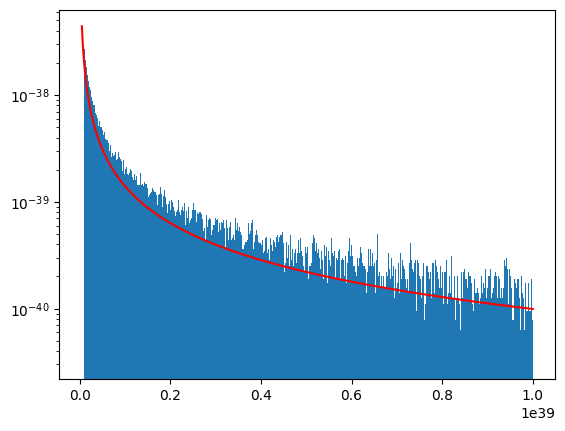

In [64]:
gamma = -1.15
#gamma = -0.95

Emin = 1e37 * u.erg
Echar = 2.38e41 * u.erg

# Normalized Schechter distribution
schechter_pdf = lambda E: (E / Echar)**gamma * np.exp(-E / Echar)
norm = float(gammainc(gamma+1, (Emin/Echar).to(u.dimensionless_unscaled).value)) * Echar
schechter_pdf_norm = lambda E: schechter_pdf(E) / norm

dist = get_distribution_E(
    Emin,
    Echar,
    gamma,
)

x = np.linspace(Emin/2, Emin*100, 1000)
plt.plot(x, schechter_pdf_norm(x), 'r-')
_ = plt.hist(dist, density=True, bins=x)

plt.yscale('log')

In [ ]:
Emin / rng.power(a, size=100_000)

In [5]:
from scipy.stats import pareto, powerlaw

In [ ]:
        x = (rng.pareto(-gamma-1, number_of_simulated_frbs) + 1) * Emin

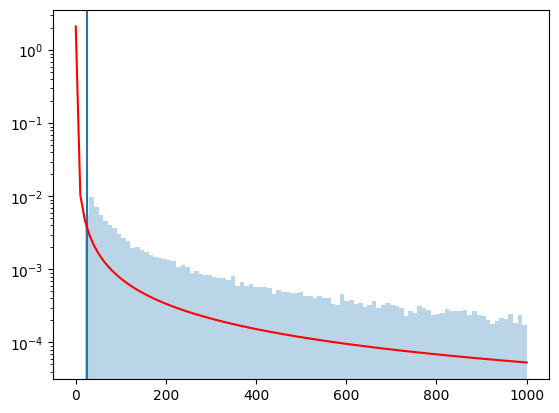

In [55]:
# Pareto

gamma = -1.15
#gamma = -0.95

Emin = 26
plt.axvline(Emin)

a = -gamma - 1
x = np.linspace(0.1, 1000, 100)
y = a / x**(a+1)
plt.plot(x, y, 'r-')

_ = plt.hist(
    (rng.pareto(a, size=100_000) + 1) * Emin,
    bins=x,
    alpha=0.3,
    density=True
)


plt.yscale('log')

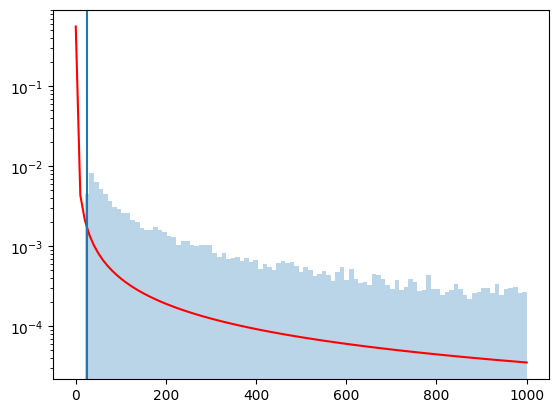

In [56]:
#gamma = -1.15
gamma = -0.95

a = gamma + 1
y = a / x**(a+1)
plt.plot(x, y, 'r-')

_ = plt.hist(
    Emin / rng.power(a, size=100_000),
    bins=x,
    alpha=0.3,
    density=True
)
plt.axvline(Emin)

plt.yscale('log')

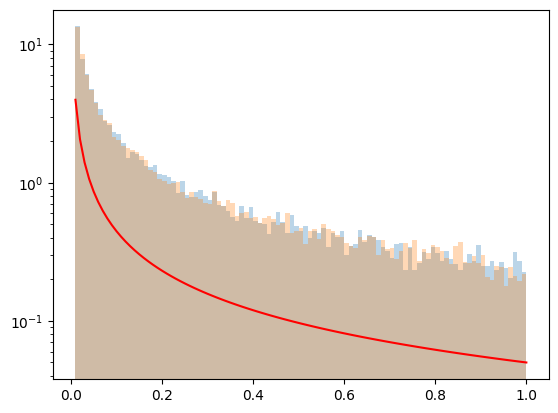

In [26]:
# Power

#gamma = -1.15
gamma = -0.95

a = gamma + 1
x = np.linspace(0.01, 1, 100)
y = a * x**(a-1)
plt.plot(x, y, 'r-')

_ = plt.hist(
    rng.power(a, size=100_000),
    bins=x,
    alpha=0.3,
    density=True
)

rv = powerlaw(a)
_ = plt.hist(
    rv.rvs(size=100_000),
    bins=x,
    alpha=0.3,
    density=True
)

plt.yscale('log')

In [24]:
y

array([4.45625469e-01, 5.50553897e-03, 2.86318077e-03, 1.95092287e-03,
       1.48555157e-03, 1.20233922e-03, 1.01144145e-03, 8.73853056e-04,
       7.69872681e-04, 6.88463122e-04, 6.22954614e-04, 5.69076244e-04,
       5.23964959e-04, 4.85628770e-04, 4.52638391e-04, 4.23941335e-04,
       3.98745216e-04, 3.76441940e-04, 3.56556978e-04, 3.38714538e-04,
       3.22613106e-04, 3.08007927e-04, 2.94698221e-04, 2.82517716e-04,
       2.71327522e-04, 2.61010708e-04, 2.51468120e-04, 2.42615116e-04,
       2.34379004e-04, 2.26696996e-04, 2.19514577e-04, 2.12784181e-04,
       2.06464118e-04, 2.00517688e-04, 1.94912459e-04, 1.89619659e-04,
       1.84613675e-04, 1.79871631e-04, 1.75373027e-04, 1.71099442e-04,
       1.67034275e-04, 1.63162524e-04, 1.59470599e-04, 1.55946158e-04,
       1.52577968e-04, 1.49355784e-04, 1.46270237e-04, 1.43312750e-04,
       1.40475449e-04, 1.37751097e-04, 1.35133027e-04, 1.32615089e-04,
       1.30191603e-04, 1.27857308e-04, 1.25607331e-04, 1.23437148e-04,
      

In [26]:
number_of_simulated_frbs = int(1e5)
number_of_simualtions = 10

rate_list = np.array([
    run_simulation(
        telescope_name='chime',
        simulate_lensed_frbs = False,
        verbose=False
    ).to(1/u.yr).value for jj in range(number_of_simualtions)
]) / u.yr

In [27]:
rate_list.mean(), rate_list.std()

(<Quantity 747.95786262 1 / yr>, <Quantity 29.89234245 1 / yr>)

In [31]:
rate_list.std() / rate_list.mean() * 100

<Quantity 3.9965276>

In [ ]:
# Detection rate

In [87]:
#FAST (https://iopscience.iop.org/article/10.3847/2041-8213/abe7f0)
n_frbs = 4
obs_time = (1667+9) * u.hour
rate = (n_frbs / obs_time).to(1/u.yr)
err = (np.sqrt(n_frbs) / obs_time).to(1/u.yr)

rate/9, err

#correct for multibeam

(<Quantity 2.32458234 1 / yr>, <Quantity 10.46062053 1 / yr>)

In [90]:
# ASKAP (https://www.nature.com/articles/s41586-018-0588-y)
n_frbs = 20
obs_time = (32_840) * u.hour
rate = (n_frbs / obs_time).to(1/u.yr)
err = (np.sqrt(n_frbs) / obs_time).to(1/u.yr)

rate/6, err

#correct for fly-eyes mode
# see also https://www.cambridge.org/core/journals/publications-of-the-astronomical-society-of-australia/article/performance-and-calibration-of-the-craft-flys-eye-fast-radio-burst-survey/6E37666300C2CBC3E208BBFA632E73ED

(<Quantity 0.88976857 1 / yr>, <Quantity 1.19374981 1 / yr>)

In [ ]:
# add Aperitif, see Connor
# add UTMOST and others from the catalog

In [ ]:
# Follow-up
from astropy.coordinates import AltAz, EarthLocation, SkyCoord
from astropy.time import Time

In [4]:
source_low_dec = SkyCoord(ra=0*u.deg, dec=-10*u.deg)
source_mid_dec = SkyCoord(ra=0*u.deg, dec=45*u.deg)
source_high_dec = SkyCoord(ra=0*u.deg, dec=89*u.deg)

In [5]:
gbt = EarthLocation.of_site('GBT')
gmrt = EarthLocation.of_site('GMRT')
eff = EarthLocation.of_site('Effelsberg')

90.0% of time the source can be observed


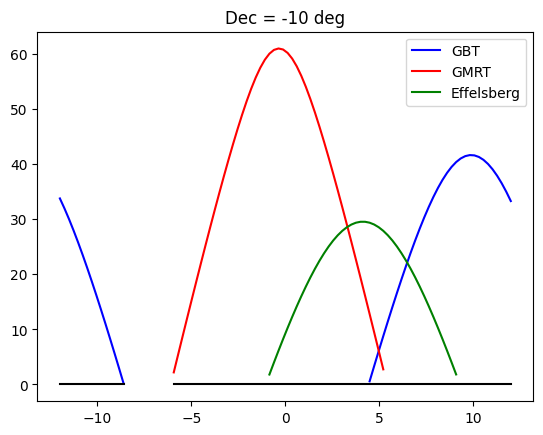

In [26]:
# Low dec
ha = np.linspace(-12, 12, 100)
t = ha*u.hour + Time('2012-7-13 00:00:00')
y_t = np.zeros_like(ha) + np.nan

# GBT
alt_gbt = source_low_dec.transform_to(AltAz(obstime=t, location=gbt)).alt
idx = alt_gbt > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_gbt.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'b-', label='GBT')
y_t[idx] = 0

# GMRT
alt_gmrt = source_low_dec.transform_to(AltAz(obstime=t, location=gmrt)).alt
idx = alt_gmrt > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_gmrt.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'r-', label='GMRT')
y_t[idx] = 0

# Effelsberg
alt_eff = source_low_dec.transform_to(AltAz(obstime=t, location=eff)).alt
idx = alt_eff > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_eff.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'g-', label='Effelsberg')
y_t[idx] = 0

plt.plot(ha, y_t, "k-")
plt.legend()
plt.title('Dec = -10 deg')

print(f'{y_t[~np.isnan(y_t)].size / y_t.size * 100:.1f}% of time the source can be observed')

100.0% of time the source can be observed


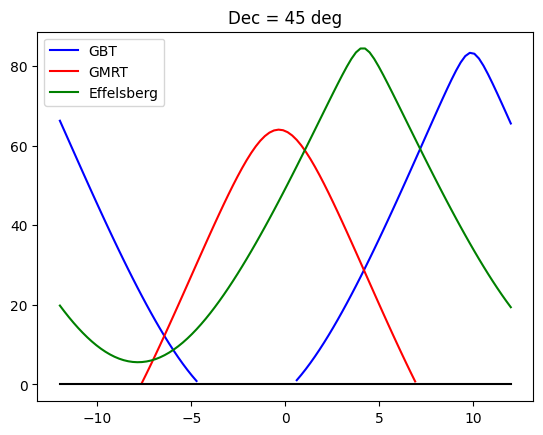

In [27]:
# Mid dec
ha = np.linspace(-12, 12, 100)
t = ha*u.hour + Time('2012-7-13 00:00:00')
y_t = np.zeros_like(ha) + np.nan

# GBT
alt_gbt = source_mid_dec.transform_to(AltAz(obstime=t, location=gbt)).alt
idx = alt_gbt > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_gbt.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'b-', label='GBT')
y_t[idx] = 0

# GMRT
alt_gmrt = source_mid_dec.transform_to(AltAz(obstime=t, location=gmrt)).alt
idx = alt_gmrt > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_gmrt.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'r-', label='GMRT')
y_t[idx] = 0

# Effelsberg
alt_eff = source_mid_dec.transform_to(AltAz(obstime=t, location=eff)).alt
idx = alt_eff > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_eff.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'g-', label='Effelsberg')
y_t[idx] = 0

plt.plot(ha, y_t, "k-")
plt.legend()
plt.title('Dec = 45 deg')

print(f'{y_t[~np.isnan(y_t)].size / y_t.size * 100:.1f}% of time the source can be observed')

100.0% of time the source can be observed


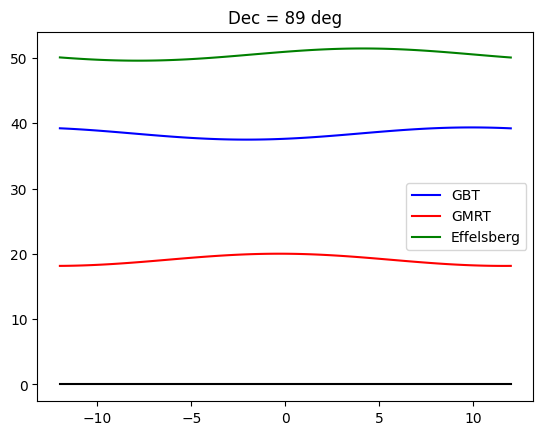

In [28]:
# High dec
ha = np.linspace(-12, 12, 100)
t = ha*u.hour + Time('2012-7-13 00:00:00')
y_t = np.zeros_like(ha) + np.nan

# GBT
alt_gbt = source_high_dec.transform_to(AltAz(obstime=t, location=gbt)).alt
idx = alt_gbt > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_gbt.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'b-', label='GBT')
y_t[idx] = 0

# GMRT
alt_gmrt = source_high_dec.transform_to(AltAz(obstime=t, location=gmrt)).alt
idx = alt_gmrt > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_gmrt.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'r-', label='GMRT')
y_t[idx] = 0

# Effelsberg
alt_eff = source_high_dec.transform_to(AltAz(obstime=t, location=eff)).alt
idx = alt_eff > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_eff.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'g-', label='Effelsberg')
y_t[idx] = 0

plt.plot(ha, y_t, "k-")
plt.legend()
plt.title('Dec = 89 deg')

print(f'{y_t[~np.isnan(y_t)].size / y_t.size * 100:.1f}% of time the source can be observed')

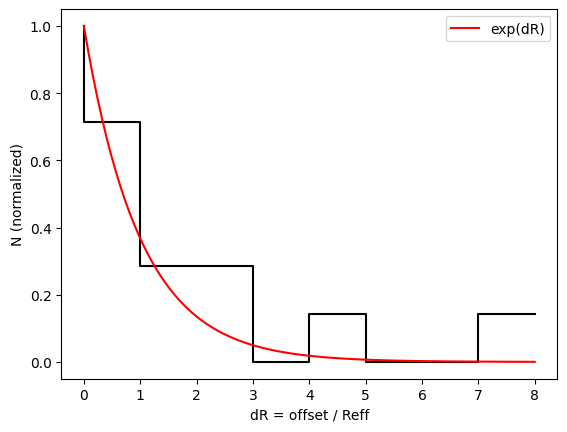

In [1125]:
# FRB radial distribution within host galaxies

#https://arxiv.org/pdf/2009.10747.pdf
#https://arxiv.org/pdf/2302.14782.pdf
#https://arxiv.org/pdf/2108.01282.pdf
#https://arxiv.org/pdf/2301.01000.pdf

# i-band and r-band
offset = np.array([0.6, 5.5, 3.4, 1.2, 2.0, 27, 6.6, 11, 3.2, 1.9, 11, 3.0, 9.87, 3.80, 10.8, 5.7, 5.9, 2.3])
reff = np.array([0.7, 3.6, 2.7, 7.2, 4.4, 3.3, 2.8, 2.1, 2.9, 3.9, 5.5, 1.6, 2.67, 6.64, 5.80, 1.78, 7.58, 2.7])

r = np.sort(offset / reff)
F = np.arange(r.size)/r.size

from scipy import stats
y_hist, bins = np.histogram(r, bins=np.arange(10))
x_hist = bins[:-1]
plt.step(x_hist, y_hist/y_hist.max(), color='k')


x = np.linspace(x_hist.min(), x_hist.max(), 100)
y = np.exp(-x)
#y = y / y.max() * 7
plt.plot(x, y, 'r-', label='exp(dR)')
plt.xlabel('dR = offset / Reff')
plt.ylabel('N (normalized)')
plt.legend()

In [1]:
import sys
sys.path.insert(0, "/arc/home/michilli/ARSpy/")

In [1]:
import sys
sys.path.append("/arc/home/michilli/.local/lib/python3.8/site-packages/")

In [2]:
import numpy as np
from arspy.ars import adaptive_rejection_sampling
import arspy
arspy

<module 'arspy' from '/arc/home/michilli/.local/lib/python3.8/site-packages/arspy/__init__.py'>

In [11]:
    gamma = -1.3
    Echar=30
    Emin=5
    """Simulated distribution of a Schechter function."""
    schechter_logpdf = lambda E: np.log((E / Echar)**gamma / Echar * np.exp(-E / Echar))
    adaptive_rejection_sampling(
        logpdf = schechter_logpdf,  # Schechter function
        a = Emin,  # Lower initial condition
        b = Echar,  # Upper initial condition
        domain = (Emin, float("inf")),  # Domain of the Energy
        n_samples = 10,
        seed=2911167007
    )

[12.861100329233185,
 9.241582899926813,
 5.879467523159431,
 13.771304112580912,
 6.769463372110595,
 28.629075515917624,
 13.878310332472786,
 41.59553148937909,
 11.339655566858509,
 6.0358931232771775]

In [335]:
z_min = 0.3
z_max = 3.

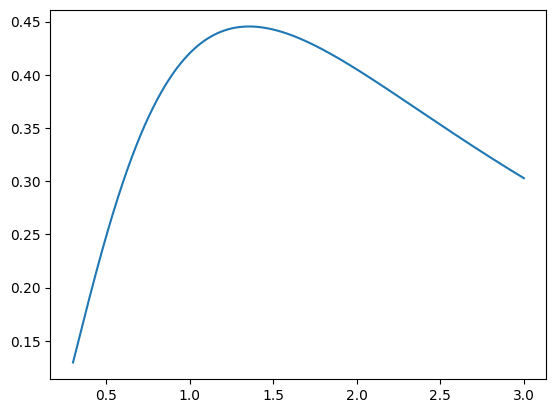